<a href="https://colab.research.google.com/github/DFwJZ/Real-time_Bot_Detection/blob/main/Cresci2015_OCSVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import pickle
from tqdm import tqdm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Jason's file path
root_path = "notebooks/data"

In [ ]:
!pwd

/notebooks/notebooks


In [ ]:
%cd ..

/notebooks


In [ ]:
!ls

CITATION.cff	    README_hd.md	     docs	     setup.py
CODE_OF_CONDUCT.md  README_ja.md	     examples	     src
CONTRIBUTING.md     README_ko.md	     hubconf.py      templates
ISSUES.md	    README_zh-hans.md	     model_cards     tests
LICENSE		    README_zh-hant.md	     notebooks	     utils
Makefile	    awesome-transformers.md  pyproject.toml
README.md	    conftest.py		     scripts
README_es.md	    docker		     setup.cfg


In [ ]:
with open(f'{root_path}/fake_tweets_df.pkl', 'rb') as f:
    df_fake_combined = pickle.load(f)

with open(f'{root_path}/genuine_tweets_df.pkl', 'rb') as f:
    df_genuine_combined = pickle.load(f)

In [ ]:
df_fake_combined.shape, df_genuine_combined.shape

((3202, 20), (1946, 20))

In [ ]:
from sklearn.model_selection import train_test_split

# Train_fake_df will be used to train VAE to get baseline model

train_fake_df, test_fake_df = train_test_split(df_fake_combined, test_size=0.2, random_state=730)

train_genuine_df, test_genuine_df = train_test_split(df_genuine_combined, test_size=0.2, random_state=730)

In [ ]:
train_fake_df.shape, test_fake_df.shape, train_genuine_df.shape, test_genuine_df.shape

((2561, 20), (641, 20), (1556, 20), (390, 20))

In [ ]:
train_fake_df_features_no_text = train_fake_df.iloc[:, :-1]
test_fake_df_features_no_text = test_fake_df.iloc[:, :-1]
train_genuine_df_features_no_text = train_genuine_df.iloc[:, :-1]
test_genuine_df_features_no_text = test_genuine_df.iloc[:, :-1]

In [ ]:
train_fake_df_features_no_text.shape, test_fake_df_features_no_text.shape, train_genuine_df_features_no_text.shape, test_genuine_df_features_no_text.shape

((2561, 19), (641, 19), (1556, 19), (390, 19))

In [ ]:
np.count_nonzero(np.isnan(train_fake_df_features_no_text)), np.count_nonzero(np.isnan(test_fake_df_features_no_text)), np.count_nonzero(np.isnan(train_genuine_df_features_no_text)), np.count_nonzero(np.isnan(test_genuine_df_features_no_text))

(93, 21, 1104, 277)

In [ ]:
train_fake_df_features_no_text_fill_nan = np.nan_to_num(train_fake_df_features_no_text, nan=0)
test_fake_df_features_no_text_fill_nan = np.nan_to_num(test_fake_df_features_no_text, nan=0)
train_genuine_df_features_no_text_fill_nan = np.nan_to_num(train_genuine_df_features_no_text, nan=0)
test_genuine_df_features_no_text_fill_nan = np.nan_to_num(test_genuine_df_features_no_text, nan=0)

In [ ]:
np.count_nonzero(np.isnan(train_fake_df_features_no_text_fill_nan)), np.count_nonzero(np.isnan(test_fake_df_features_no_text_fill_nan)), np.count_nonzero(np.isnan(train_genuine_df_features_no_text_fill_nan)), np.count_nonzero(np.isnan(test_genuine_df_features_no_text_fill_nan))

(0, 0, 0, 0)

In [ ]:
with open(f'{root_path}/train_fake_df_text_embedding_sentiments_xlmt.pkl', 'rb') as f:
    train_fake_df_text_embeddings = pickle.load(f)

with open(f'{root_path}/train_genuine_df_text_embedding_sentiments_xlmt.pkl', 'rb') as f:
    train_genuine_df_text_embeddings = pickle.load(f)

with open(f'{root_path}/test_fake_df_text_embeddings_sentiments_xlmt.pkl', 'rb') as f:
    test_fake_df_text_embeddings = pickle.load(f)

with open(f'{root_path}/test_genuine_df_text_embedding_sentiments_xlmt.pkl', 'rb') as f:
    test_genuine_df_text_embeddings = pickle.load(f)

In [ ]:
train_fake_df_text_embeddings_avg = np.squeeze(train_fake_df_text_embeddings, axis=1)
train_genuine_df_text_embeddings_avg = np.squeeze(train_genuine_df_text_embeddings, axis=1)
test_fake_df_text_embeddings_avg = np.squeeze(test_fake_df_text_embeddings, axis=1)
test_genuine_df_text_embeddings_avg = np.squeeze(test_genuine_df_text_embeddings, axis=1)

train_fake_df_text_embeddings_avg.shape, test_fake_df_text_embeddings_avg.shape, train_genuine_df_text_embeddings_avg.shape, test_genuine_df_text_embeddings_avg.shape

((2561, 771), (641, 771), (1556, 771), (390, 771))

In [ ]:
df_text = np.concatenate((train_fake_df_text_embeddings_avg, train_genuine_df_text_embeddings_avg), axis=0)
df_text_test = np.concatenate((test_fake_df_text_embeddings_avg, test_genuine_df_text_embeddings_avg), axis=0)

In [ ]:
df_non_text = np.concatenate((train_fake_df_features_no_text_fill_nan,train_genuine_df_features_no_text_fill_nan), axis=0)
df_non_text_test = np.concatenate((test_fake_df_features_no_text_fill_nan,test_genuine_df_features_no_text_fill_nan), axis=0)

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalize text embeddings
scaler_text = MinMaxScaler()
text_embeddings_scaled = scaler_text.fit_transform(df_text)

# Normalize non-text features
scaler_non_text = MinMaxScaler()
non_text_features_scaled = scaler_non_text.fit_transform(df_non_text)

# Concatenate
final_features = np.concatenate((text_embeddings_scaled, non_text_features_scaled), axis=1)

In [ ]:
# genuine train
from sklearn.preprocessing import MinMaxScaler

# Normalize text embeddings
scaler_text = MinMaxScaler()
genuine_text_embeddings_scaled = scaler_text.fit_transform(train_genuine_df_text_embeddings_avg)

# Normalize non-text features
scaler_non_text = MinMaxScaler()
genuine_non_text_features_scaled = scaler_non_text.fit_transform(train_genuine_df_features_no_text_fill_nan)

# Concatenate
genuine_train = np.concatenate((genuine_text_embeddings_scaled, genuine_non_text_features_scaled), axis=1)

In [ ]:
# fake train
from sklearn.preprocessing import MinMaxScaler

# Normalize text embeddings
scaler_text = MinMaxScaler()
fake_text_embeddings_scaled = scaler_text.fit_transform(train_fake_df_text_embeddings_avg)

# Normalize non-text features
scaler_non_text = MinMaxScaler()
fake_non_text_features_scaled = scaler_non_text.fit_transform(train_fake_df_features_no_text_fill_nan)

# Concatenate
fake_train = np.concatenate((fake_text_embeddings_scaled, fake_non_text_features_scaled), axis=1)


In [ ]:
# fake test
from sklearn.preprocessing import MinMaxScaler


# Normalize text embeddings
scaler_text = MinMaxScaler()
fake_text_embeddings_scaled_test = scaler_text.fit_transform(test_fake_df_text_embeddings_avg)

# Normalize non-text features
scaler_non_text = MinMaxScaler()
fake_non_text_features_scaled_test = scaler_non_text.fit_transform(test_fake_df_features_no_text_fill_nan)

# Concatenate
fake_test = np.concatenate((fake_text_embeddings_scaled_test, fake_non_text_features_scaled_test), axis=1)


In [ ]:
# genuine test
from sklearn.preprocessing import MinMaxScaler


# Normalize text embeddings
scaler_text = MinMaxScaler()
genuine_text_embeddings_scaled_test = scaler_text.fit_transform(test_genuine_df_text_embeddings_avg)

# Normalize non-text features
scaler_non_text = MinMaxScaler()
genuine_non_text_features_scaled_test = scaler_non_text.fit_transform(test_genuine_df_features_no_text_fill_nan)

# Concatenate
genuine_test = np.concatenate((genuine_text_embeddings_scaled_test, genuine_non_text_features_scaled_test), axis=1)


In [ ]:
fake_test.shape, genuine_test.shape

((1031, 790), (1031, 790))

train data = 80% of bot tweet

- train accuracy determined by 20% of bot tweets (unseen)

test accuracy 100% human tweet (accuracy is reversed) (aka we want low)

### OCSVM Model

In [ ]:
import numpy as np
import pandas as pd
from sklearn import svm
from sklearn.preprocessing import StandardScaler

In [ ]:
scaler = StandardScaler()
genuine_train_scaled = scaler.fit_transform(final_features)

In [ ]:
ocsvm = svm.OneClassSVM(nu=0.1, kernel='rbf', gamma='scale')

# Train the model
ocsvm.fit(genuine_train_scaled)
# import joblib
# # filename = '/content/drive/MyDrive/Bot_detection/cresci tweets/ocsvm_model_jason.joblib'
# filename = f'{root_path}/ocsvm_model_jason_727.joblib'
# joblib.dump(ocsvm, filename)

OneClassSVM(nu=0.1)

### Model test on training set

In [ ]:
# ocsvm = joblib.load(f'{root_path}/ocsvm_model.joblib')

#### On genuine train

In [ ]:
genuine_train_labels = np.full(len(genuine_train), 1)

# Predict the class of the training data
genuine_predictions_train = ocsvm.predict(genuine_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Accuracy Score for Train Human Set:", accuracy_score(genuine_train_labels, genuine_predictions_train))
print("Precision Score for Train Human Set:", precision_score(genuine_train_labels, genuine_predictions_train))
print("Recall Score for Train Human Set:", recall_score(genuine_train_labels, genuine_predictions_train))
print("F1 Score for Train Human Set:", f1_score(genuine_train_labels, genuine_predictions_train))

Accuracy Score for Train Human Set: 0.9003856041131105
Precision Score for Train Human Set: 1.0
Recall Score for Train Human Set: 0.9003856041131105
F1 Score for Train Human Set: 0.9475820087926953


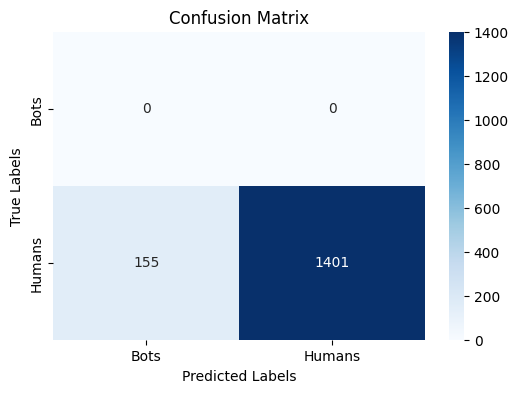

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(genuine_train_labels, genuine_predictions_train)

# Define class labels (e.g., 'Positive' and 'Negative')
class_labels = ['Bots','Humans']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


#### On fake train

In [ ]:
fake_train_labels = np.full(len(fake_train), 1)

# Predict the class of the training data
predictions_train = ocsvm.predict(genuine_train)

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

print("Accuracy Score for Train Bot Set:", accuracy_score(fake_train_labels, predictions_train))
print("Precision Score for Train Bot Set:", precision_score(fake_train_labels, predictions_train))
print("Recall Score for Train Bot Set:", recall_score(fake_train_labels, predictions_train))
print("F1 Score for Train Bot Set:", f1_score(fake_train_labels, predictions_train))

ValueError: Found input variables with inconsistent numbers of samples: [2561, 1556]

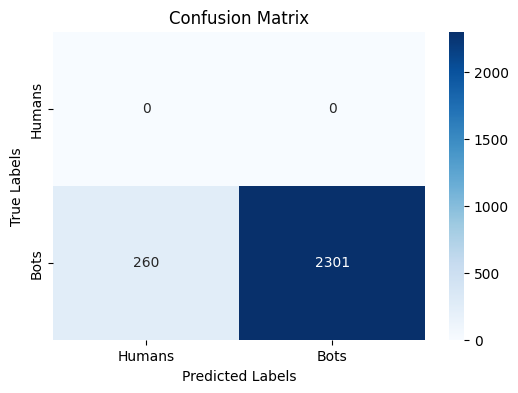

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(fake_train_labels, predictions_train)

# Define class labels (e.g., 'Positive' and 'Negative')
class_labels = ['Humans', 'Bots']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

### Model on bot test set

In [ ]:
#Accuracy on Bot Tweets Test Set
fake_test_labels = np.full(len(fake_test), 1)

# Predict anomaly scores (-1 for anomalies, 1 for normal data points)
prediction_fake_test = ocsvm.predict(fake_test)

print("Accuracy Score for Test Bot Set:", accuracy_score(fake_test_labels, prediction_fake_test))
print("Precision Score for Test Bot Set:", precision_score(fake_test_labels, prediction_fake_test))
print("Recall Score for Test Bot Set:", recall_score(fake_test_labels, prediction_fake_test))
print("F1 Score for Test Bot Set:", f1_score(fake_test_labels, prediction_fake_test))

Accuracy Score for Test Bot Set: 1.0
Precision Score for Test Bot Set: 1.0
Recall Score for Test Bot Set: 1.0
F1 Score for Test Bot Set: 1.0


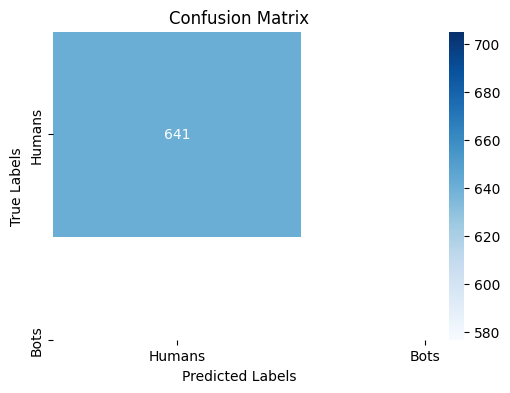

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Define class labels based on your understanding of inliers and outliers
class_labels = ['Humans', 'Bots']

# Compute the confusion matrix
conf_matrix = confusion_matrix(fake_test_labels, prediction_fake_test)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#Accuracy on Bot Tweets Test Set
genuine_test_labels = np.full(len(genuine_test), -1)

# Predict anomaly scores (-1 for anomalies, 1 for normal data points)
prediction_genuine_test = ocsvm.predict(genuine_test)

print("Accuracy Score for Test Human Set:", accuracy_score(genuine_test_labels, prediction_genuine_test))
print("Precision Score for Test Human Set:", precision_score(genuine_test_labels, prediction_genuine_test))
print("Recall Score for Test Human Set:", recall_score(genuine_test_labels, prediction_genuine_test))
print("F1 Score for Test Human Set:", f1_score(genuine_test_labels, prediction_genuine_test))

Accuracy Score for Test Human Set: 0.0
Precision Score for Test Human Set: 0.0
Recall Score for Test Human Set: 0.0
F1 Score for Test Human Set: 0.0


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


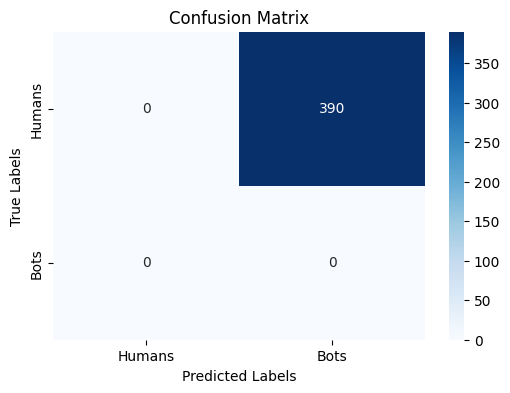

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(genuine_test_labels, prediction_genuine_test)

# Define class labels (e.g., 'Positive' and 'Negative')
class_labels = ['Humans', 'Bots']

# Create a heatmap for the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()